<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S7/EVA04_S7_50K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# mount the drive where we will save stats and loade our libraries from
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import numpy as np
import eva4datatransforms
from torchvision import transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
trans = eva4datatransforms.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)
fillmeans = (np.array(channel_means)*255).astype(np.uint8)
# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillmeans)),
                                       transforms.RandomHorizontalFlip(),
                                       ], 
                                       
                                       [transforms.RandomErasing(value = tuple(channel_means))])

# Test Phase transformations
test_transforms = trans.test_transforms()


In [6]:
tuple(fillmeans)

(125, 122, 113)

# Dataset and Creating Train/Test Split

In [7]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 3, 32, 32])
torch.Size([128])


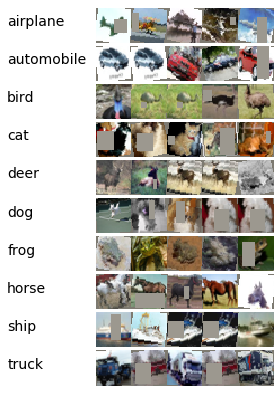

In [9]:
from __future__ import print_function
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
import eva4models
import torch
model = eva4models.Cfar10Net5()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           4,608
       BatchNorm2d-9           [-1, 32, 16, 16]              64
             ReLU-10           [-1, 32, 16, 16]               0
        MaxPool2d-11             [-1, 32, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          18,432
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

# Let's Train and test our model

In [12]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 25
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 0.602501).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0051, Accuracy: 76.89%; Test set: Average loss: 0.6025, Accuracy: 79.33%
Learning Rate = 0.040763


Epoch: 2, Train set: Average loss: 0.0053, Accuracy: 75.87%; Test set: Average loss: 0.6247, Accuracy: 78.50%
Learning Rate = 0.099460


Epoch: 3, Train set: Average loss: 0.0054, Accuracy: 75.45%; Test set: Average loss: 0.6333, Accuracy: 78.01%
Learning Rate = 0.185934


Epoch: 4, Train set: Average loss: 0.0056, Accuracy: 74.37%; Test set: Average loss: 0.6827, Accuracy: 77.04%
Learning Rate = 0.285223


Epoch: 5, Train set: Average loss: 0.0058, Accuracy: 73.99%; Test set: Average loss: 0.6944, Accuracy: 76.46%
Learning Rate = 0.380148


Epoch: 6, Train set: Average loss: 0.0058, Accuracy: 73.77%; Test set: Average loss: 0.6527, Accuracy: 77.10%
Learning Rate = 0.454285


Epoch: 7, Train set: Average loss: 0.0058, Accuracy: 74.07%; Test set: Average loss: 0.6541, Accuracy: 77.18%
Learning Rate = 0.494805


Epoch: 8, Train set: Average loss: 0.0057, Accuracy: 74.20%; Test set: Average loss: 0.6586, Accuracy: 77.12%
Learning Rate = 0.498983


Epoch: 9, Train set: Average loss: 0.0057, Accuracy: 74.30%; Test set: Average loss: 0.6794, Accuracy: 76.68%
Learning Rate = 0.490960


Epoch: 10, Train set: Average loss: 0.0056, Accuracy: 74.69%; Test set: Average loss: 0.7089, Accuracy: 76.32%
Learning Rate = 0.475192


Epoch: 11, Train set: Average loss: 0.0055, Accuracy: 74.95%; Test set: Average loss: 0.6667, Accuracy: 77.00%
Learning Rate = 0.452187


Epoch: 12, Train set: Average loss: 0.0055, Accuracy: 75.37%; Test set: Average loss: 0.6643, Accuracy: 77.08%
Learning Rate = 0.422683


Epoch: 13, Train set: Average loss: 0.0054, Accuracy: 75.57%; Test set: Average loss: 0.6125, Accuracy: 78.91%
Learning Rate = 0.387629


Epoch: 14, Train set: Average loss: 0.0053, Accuracy: 75.83%; Test set: Average loss: 0.6405, Accuracy: 78.20%
Learning Rate = 0.348151


Epoch: 15, Train set: Average loss: 0.0053, Accuracy: 76.07%; Test set: Average loss: 0.6370, Accuracy: 78.15%
Learning Rate = 0.305519


Validation loss decreased (0.602501 --> 0.595516).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0052, Accuracy: 76.55%; Test set: Average loss: 0.5955, Accuracy: 79.60%
Learning Rate = 0.261102


Epoch: 17, Train set: Average loss: 0.0051, Accuracy: 77.05%; Test set: Average loss: 0.6308, Accuracy: 78.08%
Learning Rate = 0.216329


Validation loss decreased (0.595516 --> 0.594981).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0051, Accuracy: 77.02%; Test set: Average loss: 0.5950, Accuracy: 79.36%
Learning Rate = 0.172638


Validation loss decreased (0.594981 --> 0.588472).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0049, Accuracy: 77.57%; Test set: Average loss: 0.5885, Accuracy: 80.04%
Learning Rate = 0.131433


Validation loss decreased (0.588472 --> 0.570655).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0048, Accuracy: 78.04%; Test set: Average loss: 0.5707, Accuracy: 80.41%
Learning Rate = 0.094039


Validation loss decreased (0.570655 --> 0.561522).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0048, Accuracy: 78.53%; Test set: Average loss: 0.5615, Accuracy: 80.88%
Learning Rate = 0.061658


Validation loss decreased (0.561522 --> 0.556931).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0046, Accuracy: 79.04%; Test set: Average loss: 0.5569, Accuracy: 80.90%
Learning Rate = 0.035331


Validation loss decreased (0.556931 --> 0.548317).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0046, Accuracy: 79.29%; Test set: Average loss: 0.5483, Accuracy: 81.01%
Learning Rate = 0.015903


Validation loss decreased (0.548317 --> 0.542673).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0044, Accuracy: 79.78%; Test set: Average loss: 0.5427, Accuracy: 81.59%
Learning Rate = 0.003999


Epoch: 25, Train set: Average loss: 0.0044, Accuracy: 80.02%; Test set: Average loss: 0.5431, Accuracy: 81.57%
Learning Rate = 0.000002

